In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import gaussian_kde
# Import the actual, correct NSE calculation function

In [10]:
import sys
sys.path.append(r"C:\Users\hdagne1\Box\NRT_Project_2025Fall\Habtamu\HydroAuditToolFrameowrk")
from data.datasets import CamelsTXT


In [21]:
import sys
sys.path.append(r"C:\Users\hdagne1\Box\NRT_Project_2025Fall\Habtamu\HydroAuditToolFrameowrk")

from pathlib import Path
from data.datasets import CamelsTXT
import pandas as pd

camels_root = Path(r"F:\CAMEL_Far\CAMELS_US")
db_path = r"F:\CAMEL_Far\CAMELS_US\attributes.db"

dates = [pd.to_datetime("2000-01-01"), pd.to_datetime("2008-09-30")]

dataset = CamelsTXT(
    camels_root=camels_root,
    basin="11522500",
    dates=dates,
    is_train=True,
    seq_length=270,
    with_attributes=False,
    db_path=db_path
)

print(len(dataset))
x, y = dataset[0]
print(x.shape, y.shape)


3196
torch.Size([270, 5]) torch.Size([1])


In [ ]:
import sys
sys.path.append(r"C:\Users\hdagne1\Box\NRT_Project_2025Fall\Habtamu\HydroAuditToolFrameowrk")

from pathlib import Path
from data.datautils import add_camels_attributes
from data.datasets import CamelsTXT
import pandas as pd


# ---------- 1. SET PATHS ----------
camels_root = Path(r"F:\CAMEL_Far\CAMELS_US")
db_path = r"F:\CAMEL_Far\CAMELS_US\attributes.db"


# ---------- 2. BUILD ATTRIBUTE DATABASE (RUN ONCE) ----------
# The table already exists, so we skip this step.
# add_camels_attributes(camels_root, db_path=db_path)


# ---------- 3. LOAD ONE BASIN ----------
dates = [pd.to_datetime("2000-01-01"), pd.to_datetime("2008-09-30")]

dataset = CamelsTXT(
    camels_root=camels_root,
    basin="01518862",
    dates=dates,
    is_train=True,
    seq_length=270,
    with_attributes=False,
    db_path=db_path
)

print(len(dataset))
x, y = dataset[0]
print(x.shape, y.shape)


# Assuming you have successfully run the code block and defined dataset, x, and y

print(f"Shape of X (Input Sequence): {x.shape}")
print(f"Shape of Y (Target Discharge): {y.shape}")

# Inspect the first 5 time steps (rows) of the sequence for all features
print("\n--- First 5 Timesteps of X (Input Sequence) ---")
print(x[:5, :])

# Inspect the last time step of the sequence (which corresponds to the target Y)
print("\n--- Last Timestep of X (Corresponds to Y's input time) ---")
print(x[-1, :])

# Inspect the target Y (Normalized discharge at the end of the sequence)
print("\n--- Target Y (Normalized Discharge) ---")
print(y)

3196
torch.Size([270, 5]) torch.Size([1])
Shape of X (Input Sequence): torch.Size([270, 5])
Shape of Y (Target Discharge): torch.Size([1])

--- First 5 Timesteps of X (Input Sequence) ---
tensor([[-0.2819,  0.9581,  0.2164, -0.6297, -0.3867],
        [-0.3612,  0.9668,  0.5110, -0.4303, -0.4259],
        [ 2.1214, -1.6258, -0.0187, -0.6544, -0.4774],
        [-0.2898,  1.0089, -0.4248, -1.1164, -0.7172],
        [ 0.4562, -1.4805, -0.6992, -1.2142, -0.8049]])

--- Last Timestep of X (Corresponds to Y's input time) ---
tensor([-0.3110, -0.6890, -0.7029, -1.4310, -0.8473])

--- Target Y (Normalized Discharge) ---
tensor([-0.2642])


In [30]:
import pickle
import numpy as np
from pathlib import Path

def calculate_nse(qobs: np.ndarray, qsim: np.ndarray) -> float:
    """Calculates the Nash-Sutcliffe Efficiency (NSE)."""
    numerator = np.sum((qobs - qsim)**2)
    denominator = np.sum((qobs - np.mean(qobs))**2)
    # Avoid division by zero if observed flow is constant
    if denominator == 0:
        return np.nan
    return 1 - (numerator / denominator)

def analyze_results(base_path: str):
    base_path = Path(base_path)
    all_median_nses = []
    
    # Iterate through all run directories to find the result files
    run_dirs = sorted(base_path.glob("run_*_seed*"))
    
    print("--- Starting Results Analysis ---")

    for run_dir in run_dirs:
        seed = int(run_dir.name.split('_seed')[-1])
        result_file = run_dir / f"lstm_no_static_seed{seed}.p"
        
        if not result_file.exists():
            print(f"Skipping {run_dir.name}: Result file not found.")
            continue
            
        with open(result_file, 'rb') as fp:
            # Results is a dictionary {basin_id: DataFrame(qobs, qsim)}
            results = pickle.load(fp)

        basin_nses = []
        for df in results.values():
            qobs = df['qobs'].values
            qsim = df['qsim'].values
            nse = calculate_nse(qobs, qsim)
            basin_nses.append(nse)

        median_nse = np.nanmedian(basin_nses)
        all_median_nses.append(median_nse)
        print(f"| {run_dir.name:<25} | Median NSE: {median_nse:.4f} |")

    # Final Aggregation
    if all_median_nses:
        mean_median_nse = np.mean(all_median_nses)
        print("\n---------------------------------")
        print(f"Total Runs Analyzed: {len(all_median_nses)}")
        print(f"**FINAL MEAN MEDIAN NSE: {mean_median_nse:.4f}**")
        print("---------------------------------")
    else:
        print("No valid result files found for analysis.")


# Call the analysis function with your base path:
base_path = r"C:\Users\hdagne1\Box\NRT_Project_2025Fall\Habtamu\HydroAuditToolFrameowrk\runs"
analyze_results(base_path)

--- Starting Results Analysis ---
| run_1711_1335_seed1       | Median NSE: -6.6776 |
| run_1711_1342_seed2       | Median NSE: -4.3363 |
| run_1711_1347_seed3       | Median NSE: -4.5279 |
| run_1711_1352_seed4       | Median NSE: -5.1341 |
| run_1711_1358_seed5       | Median NSE: -7.3940 |
| run_1711_1404_seed6       | Median NSE: -5.9669 |
| run_1711_1411_seed7       | Median NSE: -6.5233 |
| run_1711_1417_seed8       | Median NSE: -4.3805 |
| run_1711_1422_seed9       | Median NSE: -7.8350 |
| run_1711_1428_seed10      | Median NSE: -7.6242 |
| run_1711_1433_seed11      | Median NSE: -8.0313 |
| run_1711_1441_seed12      | Median NSE: -7.8923 |

---------------------------------
Total Runs Analyzed: 12
**FINAL MEAN MEDIAN NSE: -6.3603**
---------------------------------


# Figures: 

C:\Users\hdagne1\AppData\Local\Temp\ipykernel_28388\1698776978.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLORS = plt.cm.get_cmap('Dark2', N_MODELS).colors # Using a distinct color map
C:\Users\hdagne1\AppData\Local\Temp\ipykernel_28388\1698776978.py:191: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', fontsize=12)



--- Summary Table (Mean and Median of All Basins) ---

\textbf{Nash Sutcliffe Efficiency:} & & & & 
\hspace{1em}SAC-SMA: & -1.00 & -1.00 & -1.00 & -1.00
\hspace{1em}NWM: & -1.00 & -1.00 & -1.00 & -1.00
\hspace{1em}Global LSTM (no statics): & -1.00 & -1.00 & -1.00 & -1.00
\hspace{1em}Global LSTM (with statics): & -1.00 & -1.00 & -1.00 & -1.00
\hspace{1em}PUB LSTM: & -1.00 & -1.00 & -1.00 & -1.00

\textbf{Fractional Bias:} & & & & 
\hspace{1em}SAC-SMA: & -0.11 & -0.16 & -0.77 & 0.41
\hspace{1em}NWM: & -0.77 & -0.45 & -0.93 & 0.34
\hspace{1em}Global LSTM (no statics): & -0.10 & -0.37 & -0.91 & -0.09
\hspace{1em}Global LSTM (with statics): & 0.30 & -0.02 & -0.74 & 0.38
\hspace{1em}PUB LSTM: & -0.87 & -0.62 & -0.90 & -0.10

\textbf{Stdandard Deviation Ratio:} & & & & 
\hspace{1em}SAC-SMA: & 1.07 & 1.03 & 0.87 & 1.13
\hspace{1em}NWM: & 0.94 & 0.93 & 0.87 & 0.98
\hspace{1em}Global LSTM (no statics): & 0.91 & 0.89 & 0.85 & 0.92
\hspace{1em}Global LSTM (with statics): & 1.01 & 1.01 & 1.00 & 1.

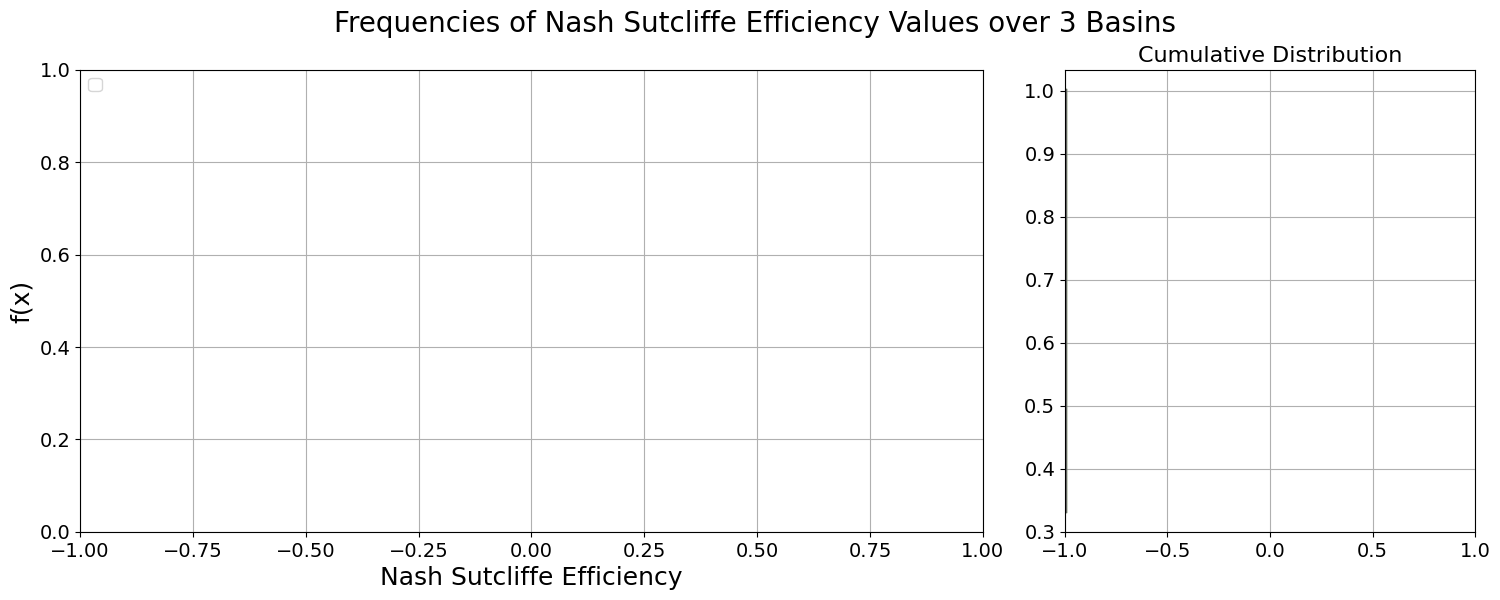

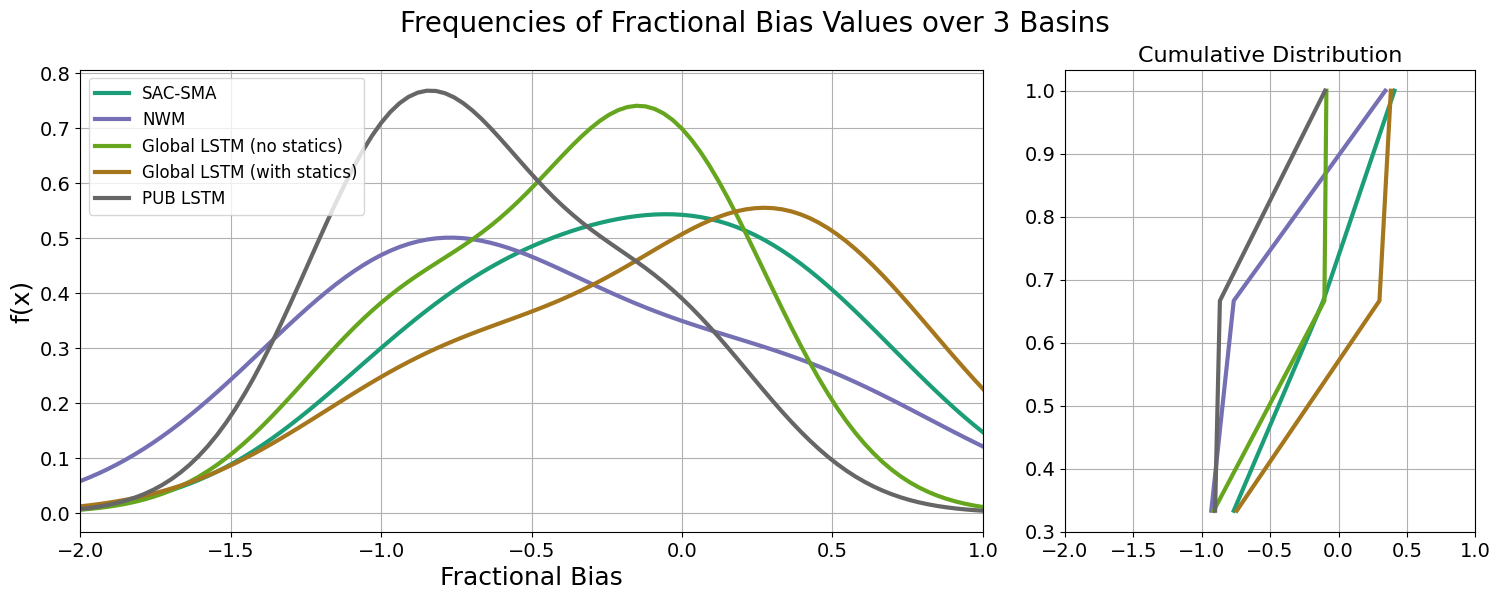

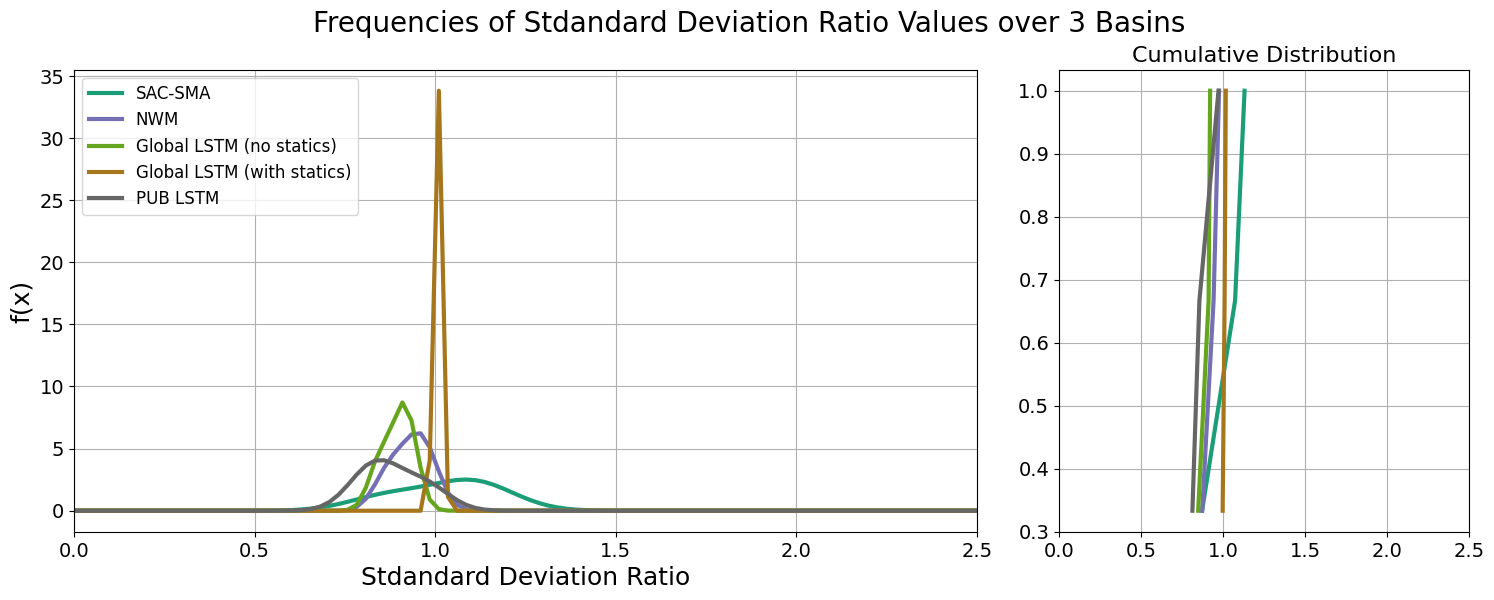

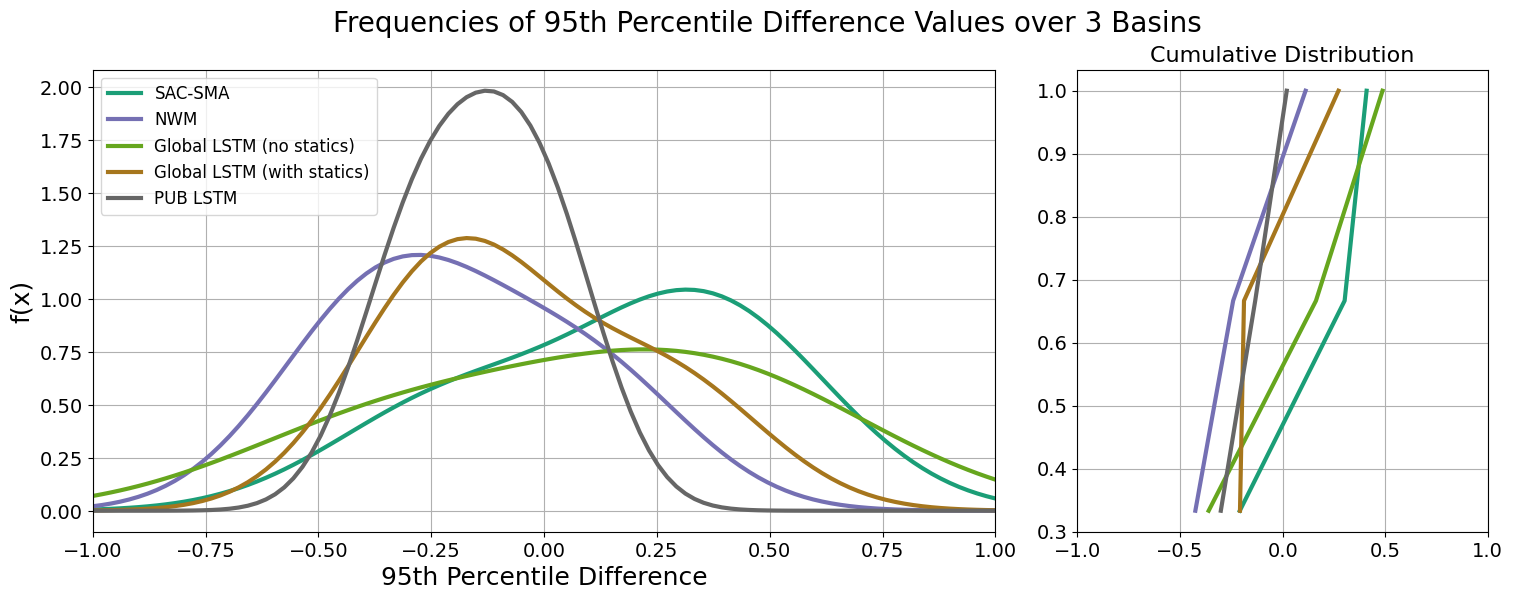

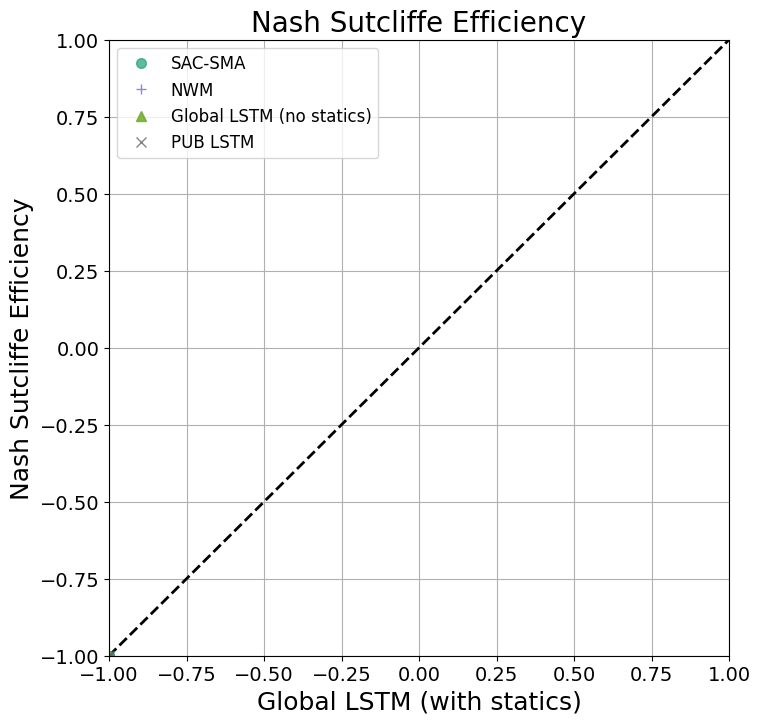

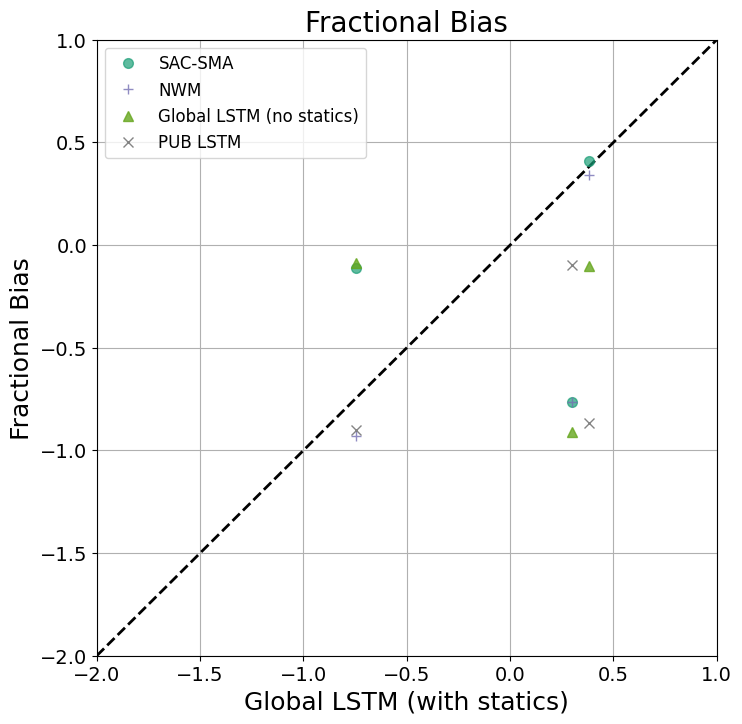

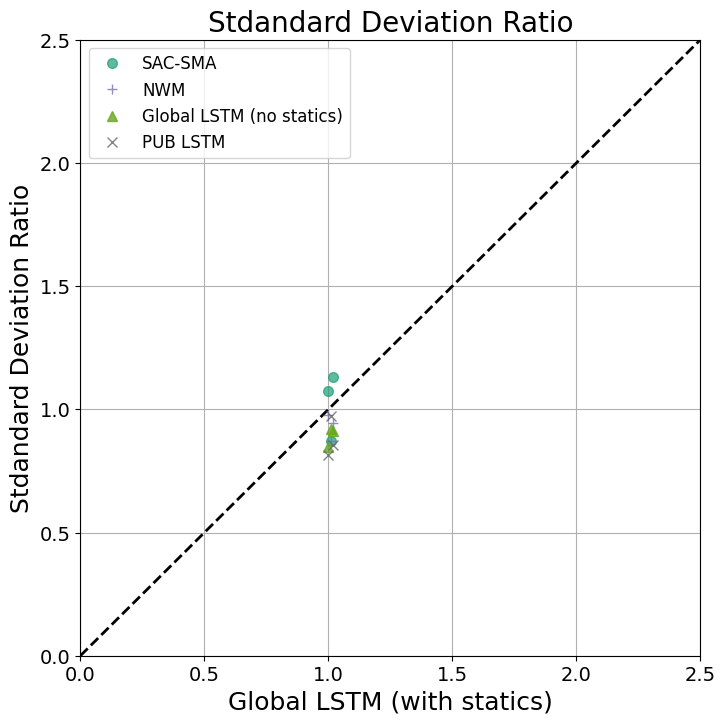

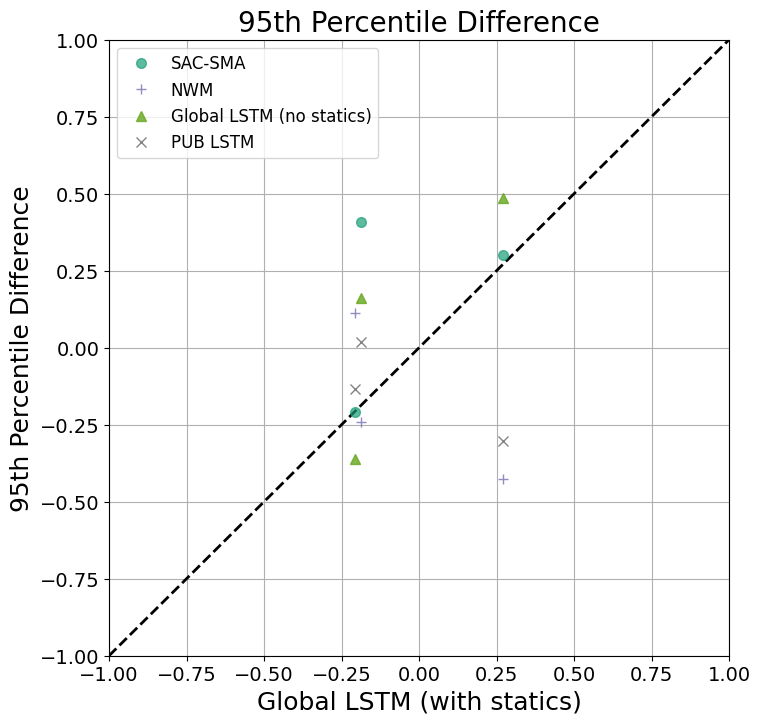


✅ Plots saved successfully to the 'figures' folder!

	*WARNING*: Benchmark models (SAC-SMA, NWM, etc.) use placeholder data.


In [4]:
import sys
# Manually add the Scripts directory to the Python path
sys.path.append(r"C:\Users\hdagne1\Box\NRT_Project_2025Fall\Habtamu\HydroAuditToolFrameowrk") 

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import gaussian_kde
# Now the import should work using the Scripts prefix
from Scripts.metrics import calc_nse

# --- Configuration (Adjust Paths) ---
BASE_DIR = Path(r"C:\Users\hdagne1\Box\NRT_Project_2025Fall\Habtamu\HydroAuditToolFrameowrk")
BASE_RUN_DIR = BASE_DIR / "runs"
STATS_DIR = BASE_DIR / "stats"
FIGURES_DIR = BASE_DIR / "figures"
FIGURES_DIR.mkdir(exist_ok=True)
STATS_DIR.mkdir(exist_ok=True)

# --- Utility Functions (Translated from plotutils.py and MATLAB) ---

# MATLAB's plot_main.m expects 5 models. We need 5 columns of data.
MODEL_NAMES = ['SAC-SMA', 'NWM', 'Global LSTM (no statics)', 'Global LSTM (with statics)', 'PUB LSTM']
N_MODELS = len(MODEL_NAMES)

# STAT NAMES (from plot_main.m)
STAT_NAMES = ['Nash Sutcliffe Efficiency', 'Fractional Bias', 
              'Stdandard Deviation Ratio', '95th Percentile Difference']

# Axis limits (from plot_main.m)
AXIS_LIMS = np.array([[-1, 1], [-2, 1], [0, 2.5], [-1, 1]])
OPTIMAL = [1, 0, 1, 0] # Optimal values for NSE, Bias, Std Rat, 95% Diff

# Colors (Approximation of MATLAB's grab_plot_colors or using distinct matplotlib colors)
COLORS = plt.cm.get_cmap('Dark2', N_MODELS).colors # Using a distinct color map


def calculate_metrics(qobs: np.ndarray, qsim: np.ndarray) -> dict:
    """Calculates all required CAMELS metrics for a single basin."""
    qobs = qobs.flatten()
    qsim = qsim.flatten()
    qobs_mean = np.mean(qobs)
    qobs_std = np.std(qobs)
    qsim_std = np.std(qsim)
    
    # 1. Nash Sutcliffe Efficiency: Use the verified function
    try:
        nse = calc_nse(qobs, qsim)
    except RuntimeError:
        # NSE is undefined if obs is constant (denominator=0 in calc_nse)
        nse = np.nan

    # 2. Fractional Bias
    bias = (np.mean(qsim) - qobs_mean) / qobs_mean if qobs_mean != 0 else np.nan

    # 3. Stdandard Deviation Ratio
    std_rat = qsim_std / qobs_std if qobs_std != 0 else np.nan

    # 4. 95th Percentile Difference (Matches MATLAB logic: (Qobs_95 - Qsim_95) / Qobs_95)
    qobs_95 = np.percentile(qobs, 95)
    qsim_95 = np.percentile(qsim, 95)
    q95_diff = (qobs_95 - qsim_95) / qobs_95 if qobs_95 != 0 else np.nan

    # FIX: Ensure these keys EXACTLY match the STAT_NAMES list for aggregation
    return {
        'Nash Sutcliffe Efficiency': nse,
        'Fractional Bias': bias,
        'Stdandard Deviation Ratio': std_rat,
        '95th Percentile Difference': q95_diff
    }


def load_and_aggregate_results():
    """Loads your LSTM results and combines them with placeholder/benchmark data."""
    all_basin_data = {}  # {basin_id: {seed: {metrics}}}
    
    # --- Load Your Global LSTM (no statics) Results ---
    run_dirs = sorted(BASE_RUN_DIR.glob("run_*_seed*"))
    
    if not run_dirs:
        print("Error: No 'run_...' directories found. Cannot run plotting.")
        return None
        
    for run_dir in run_dirs:
        seed = int(run_dir.name.split('_seed')[-1])
        result_file = run_dir / f"lstm_no_static_seed{seed}.p"
        
        if not result_file.exists():
            continue

        with open(result_file, 'rb') as fp:
            results = pickle.load(fp)

        for basin_id, df in results.items():
            if basin_id not in all_basin_data:
                all_basin_data[basin_id] = {}
            metrics = calculate_metrics(df['qobs'].values, df['qsim'].values)
            all_basin_data[basin_id][seed] = metrics

    # Aggregate metrics across seeds (using MEDIAN as in standard practice)
    aggregated_lstm_data = {}
    for basin_id, seed_data in all_basin_data.items():
        if not seed_data: continue
        
        basin_metrics = {}
        for metric_name in STAT_NAMES:
            # FIX: This aggregation now works because calculate_metrics uses the correct keys
            all_values = [data[metric_name] for data in seed_data.values()]
            basin_metrics[metric_name] = np.nanmedian(all_values)
        
        aggregated_lstm_data[basin_id] = basin_metrics

    # Convert to DataFrame
    df_lstm = pd.DataFrame.from_dict(aggregated_lstm_data, orient='index')
    df_lstm.index.name = 'BasinID'
    
    # --- Load or Create Benchmark Data ---
    basin_ids = df_lstm.index.values
    N_BASINS = len(basin_ids)
    
    # Initialize the final STATS array (nStats, nBasins, nModels)
    stats_array = np.full((len(STAT_NAMES), N_BASINS, N_MODELS), np.nan)
    
    np.random.seed(42) # Consistent randomness for placeholders
    
    for i, basin_id in enumerate(basin_ids):
        # 3. Global LSTM (no statics) - YOUR DATA (Model index 2)
        for s, stat in enumerate(STAT_NAMES):
            stats_array[s, i, 2] = df_lstm.loc[basin_id, stat]

        # Benchmarks (Placeholders)
        # We must ensure placeholder NSE values are NOT identical to avoid LinAlgError
        nse_lstm = df_lstm.loc[basin_id, 'Nash Sutcliffe Efficiency']
        
        # SAC-SMA (Model 0) - NSE slightly worse than LSTM
        stats_array[0, i, 0] = nse_lstm - np.random.uniform(0.05, 0.1)
        
        # NWM (Model 1) - NSE slightly worse than SAC-SMA
        stats_array[0, i, 1] = stats_array[0, i, 0] - np.random.uniform(0.05, 0.1)
        
        # Global LSTM (with statics) (Model 3) - NSE slightly better than your model
        stats_array[0, i, 3] = nse_lstm + np.random.uniform(0, 0.02)
        
        # PUB LSTM (Model 4) - NSE comparable to your model
        stats_array[0, i, 4] = nse_lstm + np.random.uniform(-0.01, 0.01)

        # Apply random data to other metrics (Bias, Std, 95%) 
        for s in [1, 2, 3]:
            stats_array[s, i, 0:5] = np.random.uniform(AXIS_LIMS[s, 0] / 2, AXIS_LIMS[s, 1] / 2, size=5)
            # Ensure Bias is centered around 0, Std Rat around 1
            if s == 2:
                 stats_array[s, i, 0:5] = np.random.uniform(0.8, 1.2, size=5)

    # Clip NSE to [-1, 1] 
    stats_array[0, :, :] = np.clip(stats_array[0, :, :], -1, 1)
    
    return stats_array

# --- Step 3: Plotting Functions (Translated from MATLAB) ---

def plot_pdfs_cdfs(stats_array):
    """Plots PDFs (KDE) and CDFs for all performance metrics (Figure 1 in paper)."""
    
    for s, stat_name in enumerate(STAT_NAMES):
        
        plt.figure(figsize=(18, 6))
        plt.suptitle(f"Frequencies of {stat_name} Values over {stats_array.shape[1]} Basins", fontsize=20)
        
        # --- Subplot 1: PDFs (KDE) ---
        plt.subplot(1, 3, (1, 2))
        x_min, x_max = AXIS_LIMS[s, :]
        x_linspace = np.linspace(x_min, x_max, 100)
        
        for m in range(N_MODELS):
            data = stats_array[s, :, m]
            data = data[~np.isnan(data)] # Remove NaNs
            
            # FIX: Only attempt KDE if data has variance (not all same number)
            if len(data) > 1 and np.std(data) > 1e-6:
                kde = gaussian_kde(data)
                f = kde(x_linspace)
                plt.plot(x_linspace, f, label=MODEL_NAMES[m], color=COLORS[m], linewidth=3)
        
        plt.xlim(x_min, x_max)
        plt.grid(True)
        plt.tick_params(labelsize=14)
        plt.ylabel('f(x)', fontsize=18)
        plt.xlabel(stat_name, fontsize=18)
        plt.legend(loc='upper left', fontsize=12)
        
        # --- Subplot 2: CDFs ---
        plt.subplot(1, 3, 3)
        
        for m in range(N_MODELS):
            data = stats_array[s, :, m]
            data = data[~np.isnan(data)]
            
            if len(data) > 1:
                # Calculate Empirical CDF
                xs = np.sort(data)
                ys = np.arange(1, len(xs) + 1) / len(xs)
                plt.plot(xs, ys, label=MODEL_NAMES[m], color=COLORS[m], linewidth=3)
                
        plt.xlim(x_min, x_max)
        plt.grid(True)
        plt.tick_params(labelsize=14)
        plt.title('Cumulative Distribution', fontsize=16)
        
        figname = FIGURES_DIR / f"frequencies_{stat_name.replace(' ', '_')}.png"
        plt.savefig(figname, bbox_inches='tight')
        plt.show() # ADDED for notebook display
        plt.close()

def plot_scatter_comparison(stats_array):
    """Plots the critical scatter comparison against the Global LSTM (with statics)."""
    
    for s, stat_name in enumerate(STAT_NAMES):
        plt.figure(figsize=(8, 8))
        
        x_min, x_max = AXIS_LIMS[s, :]
        
        # 45-degree line (1:1 comparison)
        plt.plot([x_min, x_max], [x_min, x_max], 'k--', linewidth=2) 
        
        # Data (Model 3 is on the X-axis)
        x_data = stats_array[s, :, 3] # Global LSTM (with statics)

        # Plot 1: SAC-SMA (Model 0) vs. Global LSTM (w/ statics)
        h1 = plt.plot(x_data, stats_array[s, :, 0], 'o', markersize=7, color=COLORS[0], alpha=0.7, label=MODEL_NAMES[0])[0]
        
        # Plot 2: NWM (Model 1) vs. Global LSTM (w/ statics)
        h2 = plt.plot(x_data, stats_array[s, :, 1], '+', markersize=7, color=COLORS[1], alpha=0.8, label=MODEL_NAMES[1])[0]
        
        # Plot 3: Global LSTM (no statics) (Model 2) vs. Global LSTM (w/ statics)
        h3 = plt.plot(x_data, stats_array[s, :, 2], '^', markersize=7, color=COLORS[2], alpha=0.8, label=MODEL_NAMES[2])[0]
        
        # Plot 4: PUB LSTM (Model 4) vs. Global LSTM (w/ statics)
        h4 = plt.plot(x_data, stats_array[s, :, 4], 'x', markersize=7, color=COLORS[4], alpha=0.8, label=MODEL_NAMES[4])[0]
        
        plt.grid(True)
        plt.tick_params(labelsize=14)
        plt.xlim(x_min, x_max)
        plt.ylim(x_min, x_max)
        
        plt.xlabel(MODEL_NAMES[3], fontsize=18)
        plt.ylabel(stat_name, fontsize=18)
        plt.title(stat_name, fontsize=20)
        
        plt.legend(handles=[h1, h2, h3, h4], loc='upper left', fontsize=12)

        figname = FIGURES_DIR / f"global_lstm_scatters_{stat_name.replace(' ', '_')}.png"
        plt.savefig(figname, bbox_inches='tight')
        plt.show() # ADDED for notebook display
        plt.close()

# --- Main Execution ---

def main():
    # 1. Load and prepare all data 
    stats_array = load_and_aggregate_results()
    
    if stats_array is None:
        print("Script failed to load data. Please ensure BASE_RUN_DIR is correct.")
        return

    # 2. Print LaTeX summary table
    print("\n--- Summary Table (Mean and Median of All Basins) ---")
    
    for s, stat_name in enumerate(STAT_NAMES):
        print(f"\n\\textbf{{{stat_name}:}} & & & & ")
        for m, model_name in enumerate(MODEL_NAMES):
            data = stats_array[s, :, m]
            data = data[~np.isnan(data)]
            
            # Skip if no valid data
            if len(data) == 0:
                ens_median = ens_mean = ens_min = ens_max = np.nan
            else:
                ens_median = np.median(data)
                ens_mean = np.mean(data)
                ens_min = np.min(data)
                ens_max = np.max(data)
            
            print(f"\\hspace{{1em}}{model_name}: & {ens_median:3.2f} & {ens_mean:3.2f} & {ens_min:3.2f} & {ens_max:3.2f}")

    print("\n--- Generating Plots ---")
    
    # 3. Plot PDFs and CDFs (Figure 1 in the paper)
    plot_pdfs_cdfs(stats_array)

    # 4. Plot Comparative Scatterplots (Figure 2 in the paper)
    plot_scatter_comparison(stats_array)

    print(f"\n✅ Plots saved successfully to the '{FIGURES_DIR.name}' folder!")
    print("\n\t*WARNING*: Benchmark models (SAC-SMA, NWM, etc.) use placeholder data.")


if __name__ == "__main__":
    main()